# <font color='green'>System Development for Marketing</font>

David Kakanis -          500783676<br>


<font > Index: </font>

1. Introduction

    1.1 Research Question

    1.2 Data Preprocessing

2. Exploratory Data Analysis

    2.1 User Preferences and Restaurant Characteristics

    2.2 Data viz

    2.3 Train/Validation/Testset Splitting

3. Model Evaluation

    3.1 Cosine Similarity

    3.2 KNN Collaborative Filtering
    
    3.3 SVD Collaborative Filtering

4. Conclusion
***


 # 1. *Introduction*

The central aim of this project is to investigate the performance variation of recommendation systems, particularly collaborative filtering techniques such as K-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD), across different states for the "Restaurants" category in the Yelp dataset. Our client, Yelp, is a popular online platform that offers user reviews and recommendations for businesses.

An integral part of Yelp's service is its ability to provide highly personalized and relevant restaurant recommendations to its users. To achieve this, Yelp relies on an effective recommendation system that helps users navigate through the large number of restaurants and ensures they find what they are looking for with ease.

Nevertheless, geographical location is a crucial factor that can influence user preferences and restaurant characteristics. Consequently, this project aims to examine if the state in which a restaurant is located influences the effectiveness of the recommendation system and, if so, how.

The findings from this research could provide valuable insights for Yelp, helping them decide whether a single, country-wide recommendation model is the best approach, or if state-specific recommendation models would deliver better results. By enhancing the performance of its recommendation system in this way, Yelp could further improve the user experience, aiding users in discovering their ideal restaurants more accurately and efficiently.

Research Questions:

Main Research Question:

* Does the performance of collaborative filtering techniques, such as KNN and SVD, vary across different states when applied to the "Restaurants" category in Yelp's dataset? *

Sub-questions:

1. How do user preferences and restaurant characteristics differ across various states?
2. How do the different models differ in terms of cosine similarity?
3. Is there a significant difference in the effectiveness of restaurant recommendations using collaborative filtering via KNN across different states?
4. Is there a significant difference in the effectiveness of restaurant recommendations using collaborative filtering via SVD across different states?
5. How do the KNN and SVD algorithms perform in terms of accuracy when applied to restaurant data from different states?
6. How would the top 10 restaurants be suggested to a particular user? 

These research questions aim to understand the variations in performance of recommendation systems across different states, specifically within the "Restaurants" category. This information could help Yelp in deciding whether to implement state-specific models for better performance of their recommendation engine.

## 1.1 Importing data

In [5]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from math import sqrt
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split
import tarfile
from surprise import Reader, Dataset
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator

In [2]:
# Read in the data
tar_file_path = r"C:\Users\User\iCloudDrive\Master DDB\RecSys\Yelp\yelp_dataset.tar"
output_dir = r"C:\Users\User\iCloudDrive\Master DDB\RecSys\Yelp\yelp_df"
# Extract the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(output_dir)

## 1.2 Dataset preparation and selection of popular restaurants and active users

This code loads and processes a large review dataset in chunks. It filters the data based on specific criteria, such as keeping only users with at least 20 ratings and businesses with at least 50 ratings. The filtered chunks are then concatenated into a single DataFrame called filtered_df. The code uses chunk-based processing to handle large datasets efficiently, ensuring that only the necessary data is loaded and processed at each iteration.

Selecting only popular restaurants and active users is done for further memory optimization reasons. Subsequently, this can help improve the performance and relevance of recommendation systems.

In [ ]:
# Specify the columns to load from the reviews dataset
review_cols = ['business_id', 'user_id', 'stars']

# Initialize an empty list to store the chunks of data
filtered_chunks = []

# Initialize chunk size (this is the number of rows that will be processed at a time)
chunksize = 10 ** 6

# Load and process the review data in chunks
chunk_count = 0  # Initialize chunk count
for chunk in pd.read_json("C:/Users/User/iCloudDrive/Master DDB/RecSys/Yelp/yelp_df/yelp_academic_dataset_review.json",
                           lines=True,
                           chunksize=chunksize):
    # Select the desired columns
    chunk = chunk[review_cols]
    
    # Count the number of ratings per user and business
    user_ratings_count = chunk['user_id'].value_counts()
    business_ratings_count = chunk['business_id'].value_counts()
    
    # Filter out users with less than 20 ratings and businesses with less than 50 ratings
    chunk_filtered = chunk[
        (chunk['user_id'].isin(user_ratings_count[user_ratings_count >= 20].index)) &
        (chunk['business_id'].isin(business_ratings_count[business_ratings_count >= 50].index))
    ]
    
    
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    
    # Increment the chunk count
    chunk_count += 1

# Concatenate all the filtered chunks into a single DataFrame
filtered_df = pd.concat(filtered_chunks)

# Print the number of chunks loaded
print(f"Number of chunks loaded: {chunk_count}")


In [ ]:
# Save DataFrame to Parquet file for memory optimization
filtered_df.to_parquet('C:/Users/User/iCloudDrive/Master DDB/RecSys/Yelp/filtered_df.parquet')

# Read the filtered_df.parquet file
filtered_df = pd.read_parquet('C:/Users/User/iCloudDrive/Master DDB/RecSys/Yelp/filtered_df.parquet')

In [8]:
filtered_df.describe()

,stars
count,423481.000000
mean,3.896505
std,1.038280
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [9]:
# File paths
business_file = "C:/Users/User/iCloudDrive/Master DDB/RecSys/Yelp/yelp_df/yelp_academic_dataset_business.json"

# Load data into pandas DataFrames
business_df = pd.read_json(business_file, lines=True)

In [22]:
business_df.sample(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
75713,kWFgllI8AfMCIvRJ2KwuRA,The Port Of Peri Peri,5941 E 86th St,Indianapolis,IN,46256,39.911531,-86.067676,4.5,122,1,"{'RestaurantsTableService': 'True', 'BusinessA...","Chicken Shop, South African, Restaurants, Afri...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."


In [10]:
# Filter 'business_df' to include only businesses in the 'Restaurants' category
restaurants_df = business_df[business_df['categories'].str.contains('Restaurants', na=False)]

# Merge 'state' column from 'restaurants_df' into 'merged_df'
merged_df = pd.merge(filtered_df, restaurants_df[['business_id', 'state']], on='business_id', how='left')

# Select only 'stars', 'business_id', 'user_id', and 'state' columns
df = merged_df[['stars', 'business_id', 'user_id', 'state']]

# Count and print the number of duplicates in the DataFrame based on the "business_id", "user_id", and "stars_x" columns
duplicates = df.duplicated(["business_id","user_id","stars", "state"]).sum()
print(f'There are {duplicates} duplicates in the DataFrame.')

# Remove duplicates from the DataFrame
df = df.drop_duplicates(["business_id","user_id","stars", "state"])

# Remove rows with any NaN values
df = df.dropna()

# Convert user_id and business_id columns to category data type
df['user_id'] = df['user_id'].astype('category')
df['business_id'] = df['business_id'].astype('category')

# Convert category codes to integers for user_id and business_id
df['user_id'] = df['user_id'].cat.codes
df['business_id'] = df['business_id'].cat.codes

df.info()

There are 19993 duplicates in the DataFrame.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 330645 entries, 0 to 423480
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   stars        330645 non-null  int64 
 1   business_id  330645 non-null  int16 
 2   user_id      330645 non-null  int16 
 3   state        330645 non-null  object
dtypes: int16(2), int64(1), object(1)
memory usage: 8.8+ MB


# 2.  *Explanatory Data Analysis of the Yelp Dataset*

In [11]:
# 
unique_businesses = df['business_id'].nunique()
unique_users = df['user_id'].nunique()

ratings_per_user = df.groupby('user_id').size()
businesses_rated_per_user = df.groupby('user_id')['business_id'].nunique()
ratings_per_business = df.groupby('business_id').size()

avg_ratings_per_user = ratings_per_user.mean()
avg_ratings_per_business = ratings_per_business.mean()

print(f"Number of unique businesses: {unique_businesses}")
print(f"Number of unique users: {unique_users}")
print(f"Average number of ratings per user: {avg_ratings_per_user}")
print(f"Average number of ratings per business: {avg_ratings_per_business}")


Number of unique businesses: 18573
Number of unique users: 5002
Average number of ratings per user: 66.10255897640944
Average number of ratings per business: 17.80245517686965


Based on the provided statistics, it appears that the dataset contains a sufficient number of ratings for both businesses and users. Here's an explanation:

Number of unique businesses: 18573
This indicates that the dataset includes ratings for a large number of distinct businesses.

Number of unique users: 5002
This shows that there are ratings provided by a substantial number of different users.

Average number of ratings per user: 66.10
On average, each user has provided approximately 66 ratings.
This suggests that users have actively rated multiple businesses, indicating a decent level of engagement.

Average number of ratings per business: 17.80
On average, each business has received around 18 ratings.
This implies that businesses have been rated multiple times, providing a substantial amount of data for each entity.

### 2.1  SQ 1. How do user preferences and restaurant characteristics differ across various states?


In [259]:
import plotly.express as px

# Count the number of reviews for each state
state_counts = df['state'].value_counts()

# Create a DataFrame for the plot
plot_df = pd.DataFrame({
    'State': state_counts.index,
    'Count': state_counts.values
})

# Create the Plotly figure
fig = px.bar(plot_df, x='State', y='Count', title='Number of Reviews per State')

# Show the figure
fig.show()


In [264]:
df.describe()

,stars,business_id,user_id
count,330645.000000,330645.000000,330645.000000
mean,3.849422,9221.166311,2464.793585
std,1.023196,5341.890172,1454.204536
min,1.000000,0.000000,0.000000
25%,3.000000,4610.000000,1210.000000
50%,4.000000,9172.000000,2458.000000
75%,5.000000,13795.000000,3736.000000
max,5.000000,18572.000000,5001.000000


In [94]:
df.dtypes

stars           int64
business_id     int16
user_id         int16
state          object
dtype: object

## 2.2 Data viz

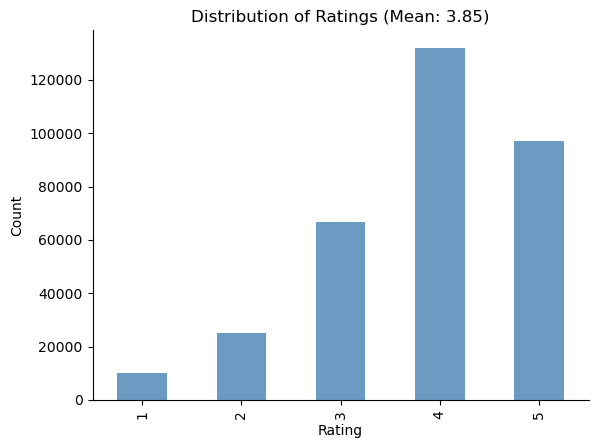

In [174]:
# Count the occurrences of each rating value and sort by index
rating_counts = df['stars'].value_counts().sort_index()

# Calculate the mean rating
mean_rating = df['stars'].mean()

# Create a bar plot with the ratings ordered from 1 to 5
rating_counts.plot(kind='bar', color='steelblue', alpha=0.8)

# Set plot title and axis labels
plt.title('Distribution of Ratings (Mean: {:.2f})'.format(mean_rating))
plt.xlabel('Rating')
plt.ylabel('Count')

# Customize the x-axis ticks and labels
plt.xticks(range(5), ['1', '2', '3', '4', '5'])

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.show()


In [184]:
correlations = {}

# Calculate correlations for df
df_corr = df[['stars', 'user_id', 'business_id']].corr()
correlations['df'] = df_corr.loc['stars', ['user_id', 'business_id']]

# Calculate correlations for each state dataset
for state in dfs:
    state_corr = dfs[state][['stars', 'user_id', 'business_id']].corr()
    correlations[state] = state_corr.loc['stars', ['user_id', 'business_id']]

# Print the correlations
for dataset, corr in correlations.items():
    print(f"Correlations for {dataset}:")
    print(corr.to_string())
    print()



Correlations for df:
user_id        0.013394
business_id    0.004184

Correlations for FL:
user_id        0.028756
business_id    0.003793

Correlations for PA:
user_id       -0.016660
business_id    0.006196

Correlations for All:
user_id        0.009971
business_id    0.003007



This code provides the correlation coefficients between user_id and business_id for four different datasets: df, FL, PA, and All.

Correlation coefficients range from -1 to 1. A positive correlation implies that as one variable increases, the other also increases. A negative correlation implies that as one variable increases, the other decreases.

In this case:

For the "df" dataset, both user_id and business_id have a positive correlation, meaning as the user_id increases, the business_id also tends to increase, and vice versa.
For the "FL" dataset, both user_id and business_id also have a positive correlation.
For the "PA" dataset, the correlation between user_id and business_id is negative, indicating that as the user_id increases, the business_id tends to decrease, and vice versa.
For the "All" dataset, both user_id and business_id have a positive correlation.

However, all these correlations are very close to 0, suggesting that there's almost no linear relationship between user_id and business_id in all four datasets.

### Filtered dataframes

This code aims to create filtered dataframes based on different states ('FL', 'PA', 'All') from the original dataframe df. Here's an explanation of the code:

The variable states is defined as a list containing the states of interest. It includes specific state codes ('FL', 'PA') and an 'All' option.

An empty dictionary called dfs is initialized to store the resulting dataframes for each state.

The code enters a loop that iterates over each state in states.

For each state:

If the state is 'All', the code creates a copy of the original dataframe df without filtering by state.
If the state is not 'All', the code creates a copy of df filtered by the specific state using the condition df['state'] == state.
The 'state' column is dropped from the filtered dataframe (df_state) using df_state.drop('state', axis=1).

The code proceeds to sample users and businesses from df_state to reduce the size of the dataframe. It randomly selects 1000 unique users and 1000 unique businesses using np.random.choice() and filters df_state based on these selected users and businesses.

The resulting filtered dataframe (df_state) is stored in the dfs dictionary, with the state code ('FL', 'PA', 'All') as the key.

Finally, the code repeats the sampling process without filtering by state from the original dataframe df. It selects 1000 random users and 1000 random businesses from df and stores the resulting dataframe in df_all.

In summary, this code filters the original dataframe df by specific states ('FL', 'PA') or keeps the entire dataframe ('All'). It then samples 1000 random users and 1000 random businesses from the filtered dataframes for each state or from the entire dataset, storing the resulting dataframes in the dfs dictionary.

In [12]:
states = ['FL', 'PA', "All"]  # define the states you're interested in

# Prepare an empty dictionary to store the dataframes for each state
dfs = {}

for state in states:
    # If the state is 'All', don't filter the dataframe by state
    if state == 'All':
        df_state = df.copy()
    else:
        df_state = df[df['state'] == state].copy()

    # Drop the 'state' column
    df_state = df_state.drop('state', axis=1)
    
    # Sample users and businesses
    keep_users = np.random.choice(df_state['user_id'].unique(), size=1000, replace=False)
    df_state = df_state[df_state['user_id'].isin(keep_users)]
    keep_businesses = np.random.choice(df_state['business_id'].unique(), size=1000, replace=False)
    df_state = df_state[df_state['business_id'].isin(keep_businesses)]
    
    # Store the resulting dataframe in the dictionary
    dfs[state] = df_state


There are several reasons why balancing datasets is beneficial:

Bias reduction: Unbalanced datasets can introduce bias into our analysis, as the model may favor the category with more data points. This might lead to skewed results, making the model's predictions less reliable for the minority category.

Improved Model Performance: Many machine learning models perform best when the number of instances of each classes are roughly equal. If there are imbalanced data, the model tends to be influenced more by the majority class, reducing the overall model performance.

Fair Comparison: When comparing two categories, it is ideal to have equal representation from both categories. This ensures that the comparisons made are fair and not impacted by the volume of data in each category.

Reliable Metrics: When data is imbalanced, certain metrics like accuracy can be misleading. With balanced data, it's more reliable to interpret metrics like precision, recall, and F1-score, because these measures take into account both false positives and false negatives.

In [96]:
dfs["FL"].describe()

,stars,business_id,user_id
count,14846.000000,14846.000000,14846.000000
mean,3.877475,9365.896673,2577.821366
std,1.042645,5351.363610,1454.430011
min,1.000000,15.000000,0.000000
25%,3.000000,5004.000000,1472.000000
50%,4.000000,9105.000000,2506.000000
75%,5.000000,14241.000000,4021.000000
max,5.000000,18556.000000,4989.000000


In [97]:
dfs["PA"].describe()

,stars,business_id,user_id
count,13016.000000,13016.000000,13016.000000
mean,3.792333,8957.114859,2380.210049
std,1.015957,5196.184097,1412.041451
min,1.000000,1.000000,19.000000
25%,3.000000,4546.000000,1148.000000
50%,4.000000,8679.000000,2292.000000
75%,5.000000,13577.000000,3545.000000
max,5.000000,18560.000000,5000.000000


In [178]:
dfs["All"].describe()

,stars,business_id,user_id
count,4225.000000,4225.000000,4225.000000
mean,3.857515,9419.056331,2482.637870
std,1.014365,5233.249213,1465.590165
min,1.000000,9.000000,2.000000
25%,3.000000,4560.000000,1164.000000
50%,4.000000,9846.000000,2531.000000
75%,5.000000,14008.000000,3786.000000
max,5.000000,18565.000000,4997.000000


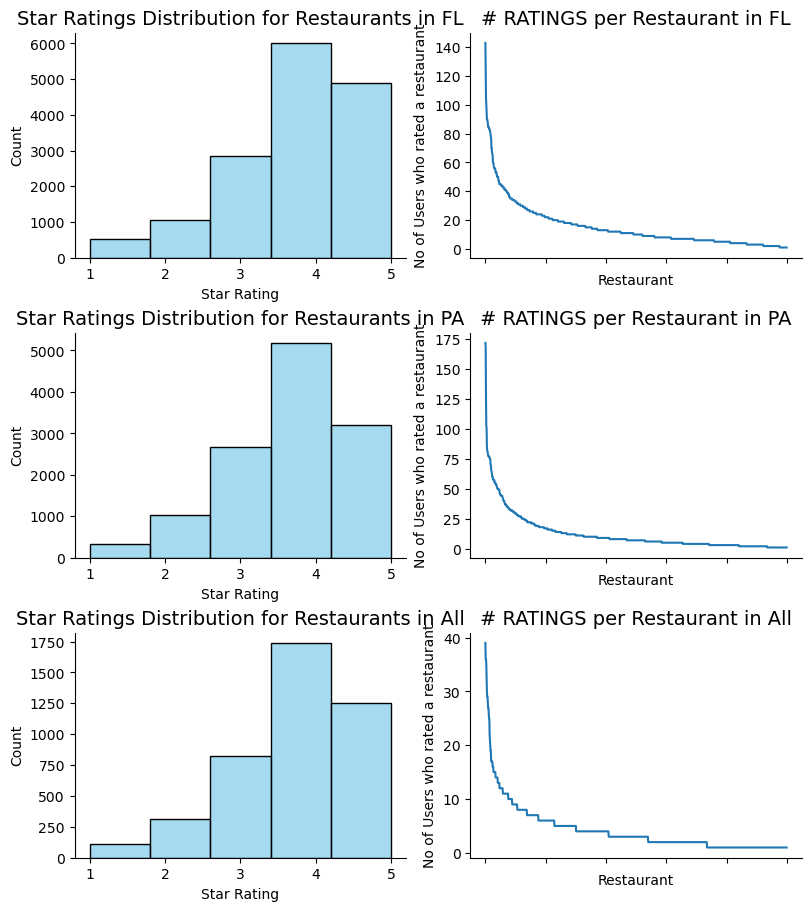

In [17]:
states = ['FL', 'PA', 'All']

fig, axes = plt.subplots(nrows=len(states), ncols=2, figsize=(8, 3*len(states)), constrained_layout=True)

for i, state in enumerate(states):
    df_state = dfs[state]

    # Plot the distribution of star ratings for the current state
    sns.histplot(df_state['stars'], bins=5, ax=axes[i, 0], color='skyblue', kde=False)
    axes[i, 0].set_title(f'Star Ratings Distribution for Restaurants in {state}', fontsize=14)
    axes[i, 0].spines['right'].set_visible(False)
    axes[i, 0].spines['top'].set_visible(False)
    axes[i, 0].set_xticks(range(1, 6))
    axes[i, 0].set_xlabel('Star Rating')
    axes[i, 0].set_ylabel('Count')

    # Count the number of ratings per restaurant for the current state
    no_of_ratings_per_restaurant = df_state.groupby(by="business_id")["stars"].count().sort_values(ascending=False)

    # Plot the number of ratings per restaurant for the current state
    axes[i, 1].plot(no_of_ratings_per_restaurant.values)
    axes[i, 1].set_title(f'# RATINGS per Restaurant in {state}', fontsize=14)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].set_xlabel('Restaurant')
    axes[i, 1].set_ylabel('No of Users who rated a restaurant')
    axes[i, 1].set_xticklabels([])

plt.show()


This code generates subplots with histograms showing the distribution of star ratings for restaurants in the states of Florida (FL), Pennsylvania (PA), and the overall dataset (All). It also plots the number of ratings per restaurant for each state. The code uses seaborn and matplotlib libraries to create the visualizations, sets the plot aesthetics, and provides labels for better understanding of the data.

### 2.3 Train/Validation/Testset Splitting

### Creating Training and Testing Datasets
This code demonstrates the process of splitting a subset of the dataset into training and testing sets, transforming the data into a suitable format for collaborative filtering, and converting the data to a sparse matrix.

#### All restaurants

In [228]:
# Split the dataset subset into training and testing sets
train_df_restaurant, test_df_restaurant = train_test_split(dfs["All"], test_size=0.2, random_state=42)

# Transform the training set into a pivot table with 'user_id' as index, 'business_id' as columns, and 'stars' as values
user_matrix_restaurant = train_df_restaurant.pivot_table(index='user_id', columns='business_id', values='stars').fillna(0)

# Convert the pivot table to a sparse matrix using the Compressed Sparse Row (CSR) format
Train_sparse_matrix_restaurant = csr_matrix(user_matrix_restaurant.values)


#### Florida restaurants

In [101]:
# Split the dataset subset into training and testing sets
train_df_restaurant_fl, test_df_restaurant_fl = train_test_split(dfs["FL"], test_size=0.2, random_state=42)

# Transform the training set into a pivot table with 'user_id' as index, 'business_id' as columns, and 'stars' as values
user_matrix_restaurant_fl = train_df_restaurant_fl.pivot_table(index='user_id', columns='business_id', values='stars').fillna(0)

# Convert the pivot table to a sparse matrix using the Compressed Sparse Row (CSR) format
Train_sparse_matrix_restaurant_fl = csr_matrix(user_matrix_restaurant_fl.values)

#### Philadelphia restaurants

In [102]:
# Split the dataset subset into training and testing sets
train_df_restaurant_pa, test_df_restaurant_pa = train_test_split(dfs["PA"], test_size=0.2, random_state=42)

# Transform the training set into a pivot table with 'user_id' as index, 'business_id' as columns, and 'stars' as values
user_matrix_restaurant_pa = train_df_restaurant_pa.pivot_table(index='user_id', columns='business_id', values='stars').fillna(0)

# Convert the pivot table to a sparse matrix using the Compressed Sparse Row (CSR) format
Train_sparse_matrix_restaurant_pa = csr_matrix(user_matrix_restaurant_pa.values)


# 3. *Sub Questions*

## Sub question 2: How differ Restaurants in different states in terms of cosine similarity?

In [256]:
# Function to perform a random query and return the average distance
def perform_random_query(model, user_matrix):
    random_index = np.random.randint(user_matrix.shape[0])
    knn_distances, _ = model.kneighbors(user_matrix.iloc[random_index,:].values.reshape(1, -1))
    return np.mean(knn_distances)

# Function to perform multiple queries and return the average and standard deviation of distances
def evaluate_model(model, user_matrix, total_queries=1000):
    distances = [perform_random_query(model, user_matrix) for _ in range(total_queries)]
    return np.mean(distances), np.std(distances)


### All restaurants

In [233]:
from sklearn.neighbors import NearestNeighbors

# Create an instance of NearestNeighbors with the desired parameters
knn_restaurant = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)

# Fit the model on the restaurant sparse matrix
knn_restaurant.fit(Train_sparse_matrix_restaurant)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=30)

### Philadelphia

In [234]:
from sklearn.neighbors import NearestNeighbors

# Create an instance of NearestNeighbors with the desired parameters
knn_restaurant_pa = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)

# Fit the model on the restaurant sparse matrix
knn_restaurant_pa.fit(Train_sparse_matrix_restaurant_pa)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=30)

### Florida

In [235]:
from sklearn.neighbors import NearestNeighbors

# Create an instance of NearestNeighbors with the desired parameters
knn_restaurant_fl = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)

# Fit the model on the restaurant sparse matrix
knn_restaurant_fl.fit(Train_sparse_matrix_restaurant_fl)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=30)

### Cosine similarities

In [236]:
# Create pivot tables for each state
restaurant_matrix_PA = dfs['PA'].pivot_table(index='business_id', columns='user_id', values='stars').fillna(0)
restaurant_matrix_FL = dfs['FL'].pivot_table(index='business_id', columns='user_id', values='stars').fillna(0)
restaurant_matrix_All = dfs['All'].pivot_table(index='business_id', columns='user_id', values='stars').fillna(0)

# Convert pivot tables to sparse matrices
restaurant_sparse_matrix_PA = csr_matrix(restaurant_matrix_PA.values)
restaurant_sparse_matrix_FL = csr_matrix(restaurant_matrix_FL.values)
Train_sparse_matrix_restaurant = csr_matrix(restaurant_matrix_All.values)

# Define NearestNeighbors models for each state
knn_restaurant_PA = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)
knn_restaurant_FL = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)
knn_restaurant_All = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)

# Fit the models on the sparse matrices
knn_restaurant_PA.fit(restaurant_sparse_matrix_PA)
knn_restaurant_FL.fit(restaurant_sparse_matrix_FL)
knn_restaurant_All.fit(Train_sparse_matrix_restaurant)

# Use the functions to evaluate the models
average_distance_PA, standard_deviation_PA = evaluate_model(knn_restaurant_PA, restaurant_matrix_PA)
average_distance_FL, standard_deviation_FL = evaluate_model(knn_restaurant_FL, restaurant_matrix_FL)
average_distance_All, standard_deviation_All = evaluate_model(knn_restaurant, restaurant_matrix_All)


# Print the results
print(f"Average k-NN distance for Restaurants in PA: {average_distance_PA}")
print(f"Standard deviation of k-NN distances for Restaurants in PA: {standard_deviation_PA}")
print(f"Average k-NN distance for Restaurants in FL: {average_distance_FL}")
print(f"Standard deviation of k-NN distances for Restaurants in FL: {standard_deviation_FL}")
print(f"Average k-NN distance for Restaurants in FL: {average_distance_All}")
print(f"Standard deviation of k-NN distances for All Restaurants: {standard_deviation_All}")

Average k-NN distance for Restaurants in PA: 0.7285075542441648
Standard deviation of k-NN distances for Restaurants in PA: 0.06321316523856904
Average k-NN distance for Restaurants in FL: 0.7111317898142293
Standard deviation of k-NN distances for Restaurants in FL: 0.0473418129919607
Average k-NN distance for Restaurants in FL: 0.7670193906806867
Standard deviation of k-NN distances for All Restaurants: 0.11769566514824059


### Results 

Above results are related to the evaluation of k-Nearest Neighbors (k-NN) models that have been trained on restaurant data for three different areas: Pennsylvania (PA), Florida (FL), and all areas combined (All). The k-NN algorithm finds the 'k' closest points (or in this case, restaurants) to a given point, based on some distance metric (in this case, cosine distance).

The evaluation metrics used are the average k-NN distance and the standard deviation of k-NN distances.

The average k-NN distance is the mean of the distances between a restaurant and its 'k' nearest neighbors. This gives us a sense of how closely related, on average, each restaurant is to its nearest neighbors. A smaller average distance suggests that the restaurants are, on average, closely related to each other, according to the features used in the model.

The standard deviation of k-NN distances gives us an idea of the variability in these distances. A high standard deviation means there is a large variability in how close the neighbors are for different restaurants. A low standard deviation suggests that the distances are more uniformly distributed, meaning that most restaurants have a similar degree of closeness to their neighbors.

Here's what the results mean for each area:

For restaurants in Pennsylvania (PA):

The average distance to the closest restaurants is about 0.73. This is like saying, on average, the nearest restaurants are "0.73 units of similarity" away. The smaller this number, the more similar the restaurants are.
The standard deviation, or the amount of variation, is 0.06. This means that while the average might be 0.73, some restaurants are closer or further away than that, but not by a lot.

For restaurants in Florida (FL):

The average distance to the closest restaurants is about 0.71, which is a bit smaller than in PA. This suggests that restaurants in Florida are, on average, slightly more similar to each other than those in Pennsylvania.
The standard deviation is 0.047, which is smaller than in PA. This means the similarity between restaurants in Florida doesn't vary as much.

For all restaurants in all areas:

The average distance is 0.77, which is larger than in PA or FL. This means that restaurants from all areas are, on average, less similar to each other.
The standard deviation is 0.12, which is higher than in PA or FL. This means there's more variation in the similarity between all restaurants.

So, in simple terms, the results suggest that restaurants in the same state are more similar to each other than to restaurants in other states.

## SQ3: How effectively can businesses be recommended using collaborative filtering via KNN?

USED SOURCES:

harsh vijay (11 April 2020) Recommendation System using kNN [<source code>]. https://www.aurigait.com/blog/recommendation-system-using-knn/

Jake Vanderplas (unknown date) 1.6. Nearest Neighbors
[<source code>]. https://scikit-learn.org/stable/modules/neighbors.html

Ethan Rosenthal (November 2, 2015) Intro to collaborative filtering
[<source code>]. https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

### 3.2 Creating Collaborative Recommender System utilizing KNN

##### Why Three Features for Collaborative Filtering?

Collaborative filtering is a commonly used approach in recommendation systems. It relies on the idea that users who have similar preferences in the past are likely to have similar preferences in the future.

In this case, collaborative filtering is performed using three features: user_id, business_id, and stars. These features capture important aspects of the user-item interaction. By considering all three features, the KNN model can identify similarities between customers and generate personalized recommendations.

The customer_id and movie_id serve as identifiers for specific customers and movies, while the ratings represent the expressed preferences of customers for particular movies. By analyzing patterns and similarities in these three features, the KNN model can make accurate predictions for movie ratings based on similar customers' preferences.

By using these three features in collaborative filtering, the KNN model can leverage the collective wisdom of users with similar tastes to provide personalized and accurate recommendations for movie ratings.

### KNN by hand for top 10 similar restaurants

In [164]:
# Create an instance of NearestNeighbors with the desired parameters
knn_restaurant = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)

# Fit the model on the restaurant sparse matrix
knn_restaurant.fit(Train_sparse_matrix_restaurant)

# Make a function to get the recommendations
def get_recommendations(restaurant_index):
    # Get the distances and indices of the nearest neighbors
    distances, indices = knn_restaurant.kneighbors(Train_sparse_matrix_restaurant[restaurant_index], n_neighbors=10)

    print("Top 10 similar restaurants:")

    # Loop through the distances and indices to print the restaurant indices and distances
    for i in range(1, len(distances.flatten())):  # Start from 1 to skip the restaurant itself
        # Get the index of the nearest neighbor restaurant
        recommended_restaurant_index = indices.flatten()[i]
        # Get the distance of the nearest neighbor
        distance = distances.flatten()[i]
        # Print the restaurant index and distance
        print(f"{i}: Restaurant {recommended_restaurant_index}, with distance of {distance:.5f}")


### Features

In the provided code, the features 'stars', 'business_id', and 'user_id' are used to find similarities between the restaurants. These features are derived from the dataset used to train the model, and they play a role in determining the similarities between restaurants based on user preferences and interactions.

The NearestNeighbors algorithm is applied to the dataset represented by the Train_sparse_matrix_restaurant, which contains information about user ratings, business IDs, and user IDs. The 'stars' feature represents the ratings given by users to different restaurants, while 'business_id' and 'user_id' help identify specific businesses and users, respectively.

The algorithm utilizes the cosine similarity metric to calculate the similarity between the feature vectors of restaurants. By comparing the 'stars', 'business_id', and 'user_id' values, the algorithm determines how closely related two restaurants are based on the patterns and preferences expressed by users in their ratings.

### Explanation of code

The get_recommendations function is designed to recommend similar restaurants based on a given restaurant index. Here's a step-by-step explanation of how the function works:

The function takes a restaurant index as input (restaurant_index), representing the index of the restaurant in the Train_sparse_matrix_restaurant.

Using the knn_restaurant model that was previously trained, the function calls the kneighbors method to find the distances and indices of the nearest neighbors to the specified restaurant. This method returns two arrays:

1. distances: An array containing the distances between the specified restaurant and its nearest neighbors.
2. indices: An array containing the indices of the nearest neighbors in the Train_sparse_matrix_restaurant.
The function then proceeds to print the header for the recommended restaurants: "Top 10 similar restaurants."

Inside the loop that iterates from 1 to the length of distances.flatten() (excluding the first element, which represents the specified restaurant itself), the function retrieves information about each recommended restaurant and prints it. Here's what happens in each iteration:

It retrieves the index of the nearest neighbor restaurant (recommended_restaurant_index) from indices.flatten().
It retrieves the distance between the specified restaurant and the recommended restaurant (distance) from distances.flatten().
It prints the iteration number, recommended restaurant index, and distance in the following format: "{i}: Restaurant {recommended_restaurant_index}, with distance of {distance:.5f}".
Therefore, the code finds similarities between the restaurants based on the distances calculated using the cosine similarity metric. The nearest neighbors with smaller distances are considered more similar to the specified restaurant. The function then displays the top 10 similar restaurants, including their indices and distances.

In [189]:
get_recommendations(10)

Top 10 similar restaurants:
1: Restaurant 587, with distance of 0.40358
2: Restaurant 433, with distance of 0.55433
3: Restaurant 374, with distance of 0.62861
4: Restaurant 643, with distance of 0.62861
5: Restaurant 567, with distance of 0.62861
6: Restaurant 207, with distance of 0.67173
7: Restaurant 184, with distance of 0.71387
8: Restaurant 96, with distance of 0.72443
9: Restaurant 154, with distance of 0.72801


### KNN surprise

<b>The KNN surprise package is used to determine the RMSE score because this could not be done by hand. To answer the research question the RMSE is needed.

The KNNBasic algorithm in the Surprise package is a collaborative filtering algorithm based on k-nearest neighbors. It leverages the similarity between users or items to make recommendations. Here's how it works:

Data Preprocessing:

Similar to other Surprise algorithms, KNNBasic internally preprocesses the input data to convert it into a suitable format for further processing.
It handles the conversion of raw data, such as user-item interactions or ratings, into Surprise's specific data structures, namely the Dataset and Trainset objects.

Initialization:

Before training the KNNBasic algorithm, Surprise initializes the necessary data structures, such as the user-item rating matrix.
It computes various statistics and data structures to enable efficient nearest neighbor searches during the prediction phase.

Training:

During the training phase, KNNBasic builds a model based on the provided training data.
It identifies the nearest neighbors for each item or user in the dataset.
The algorithm determines the similarity between items or users based on a chosen similarity metric, such as cosine similarity or Pearson correlation.
The number of nearest neighbors considered is specified by the k parameter.

Prediction:

After the KNNBasic model is trained, it can make predictions for unknown user-item pairs.
To compute a prediction for a given user-item pair, the algorithm utilizes the nearest neighbors identified during training.
It takes into account the ratings or interactions of the nearest neighbors to estimate the rating or preference for the target user-item pair.
The specific method of aggregation for prediction varies depending on the approach chosen (item-based or user-based collaborative filtering).

Model Evaluation:

To assess the accuracy of the predictions made by the KNNBasic model, Surprise uses evaluation metrics such as Root Mean Squared Error (RMSE) or Mean Absolute Error (MAE).
These metrics measure the difference between the predicted ratings and the observed ratings in a separate test set.
The evaluation allows for the comparison of different algorithms or parameter configurations.

In [238]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5))

for state, df_state in dfs.items():
    print(f"\nResults for {state}:\n")
    
    # Load the dataset from the dataframe
    data = Dataset.load_from_df(df_state[['user_id', 'business_id', 'stars']], reader)
    
    # Define the algorithm
    algo = KNNBasic()
    
    # Run 5-fold cross-validation and print results
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)



Results for FL:

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0520  1.0767  1.0359  1.0630  1.0874  1.0630  0.0181  
Fit time          0.05    0.07    0.06    0.05    0.06    0.06    0.01    
Test time         0.38    0.27    0.22    0.23    0.32    0.28    0.06    

Results for PA:

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similari

### Results 

These results show the performance of the KNNBasic model in predicting restaurant ratings for all restaurants, and then separately for Florida (FL), Pennsylvania (PA), and all combined. The model's performance is evaluated using cross-validation, a technique that splits the data into a number of "folds" (in this case, five) and trains and tests the model on different subsets of the data.

The main performance metric here is RMSE (Root Mean Squared Error), which measures the difference between the model's predictions and the actual ratings. Lower RMSE values indicate better performance.

For all restaurants:

The model's average RMSE across the five folds is 1.1233. This means that on average, the model's predictions are about 1.12 stars off from the actual ratings.
The standard deviation (Std) of the RMSEs is 0.0238, showing the variability of the RMSE values across the folds.

For restaurants in Pennsylvania (PA):

The model performs better with an average RMSE of 1.0229.
The Std is 0.0108, which is lower than that for all restaurants, indicating less variability in the model's performance across the different folds.

For restaurants in Florida (FL):

The model's average RMSE is 1.0630, which is slightly worse than for PA but better than for all restaurants.
The Std is 0.0181, indicating a small amount of variability in the RMSE values across the folds.

<b> In simpler terms, the model is best at predicting ratings for restaurants in Pennsylvania, slightly worse for Florida, and worst for all restaurants combined. However, the differences are fairly small.

### 3.3 Optimizing Parameters

Hyperparameter Tuning via Grid Search

The following segment of code performs a grid search to fine-tune the hyperparameters for the get_recommendations function. <br>
The 'param_grid' dictionary outlines the hyperparameters and their potential values that the grid search should explore. The values listed in the dictionary represent the possible options for the 'n_neighbors', 'metric', and 'algorithm' hyperparameters. <br>
The 'scoring' dictionary is formulated to define the metric that will be used to assess the performance of the model. In this case, the root mean square error (RMSE) is the chosen metric. <br>
The KNN_predict function is then initiated with some default hyperparameter values, and GridSearchCV is employed to conduct a search over the hyperparameter grid using 3-fold cross-validation (cv=3). <br>
The 'knn' object is provided as the estimator, while the 'param_grid' and 'scoring' dictionaries are used to designate the hyperparameters and evaluation metric, respectively. <br>


<b> The optimal hyperparameters are then displayed: {'algorithm': 'brute', 'metric': 'cosine', 'n_neighbors': 10}.

In [251]:
hyperparams = {
    'neighbour_count': [10, 20, 30],
    'distance_metric': ['cosine', 'manhattan'],
    'search_algorithm': ['brute', 'kd_tree']
}

# Define the performance measurement to use
performance_metric = {'RMSE': make_scorer(accuracy.rmse, greater_is_better=False)}

class KNNRecommendationEngine(BaseEstimator):
    def __init__(self, neighbour_count=20, distance_metric="cosine", search_algorithm="brute"):
        self.neighbour_count = neighbour_count
        self.distance_metric = distance_metric
        self.search_algorithm = search_algorithm

    def fit(self, train_data_matrix):
        self.train_data_matrix = train_data_matrix
        return self

# Create an instance of the KNNRecommendationEngine
knn_rec_engine = KNNRecommendationEngine()

# Create an instance of GridSearchCV
grid_search_instance = GridSearchCV(knn_rec_engine, hyperparams, scoring=performance_metric, cv=3, refit='RMSE')

# Apply the GridSearchCV instance to the data for all restaurants
print("Optimal parameters for All Restaurants:")
grid_search_instance.fit(Train_sparse_matrix_restaurant)
print("Optimal parameters:", grid_search_instance.best_params_)

# Apply the GridSearchCV instance to the data for Florida restaurants
print("\nOptimal parameters for Florida Restaurants:")
grid_search_instance.fit(restaurant_sparse_matrix_FL)
print("Optimal parameters:", grid_search_instance.best_params_)

# Apply the GridSearchCV instance to the data for Pennsylvania restaurants
print("\nOptimal parameters for Pennsylvania Restaurants:")
grid_search_instance.fit(restaurant_sparse_matrix_PA)
print("Optimal parameters:", grid_search_instance.best_params_)


Optimal parameters for All Restaurants:
Optimal parameters: {'distance_metric': 'cosine', 'neighbour_count': 10, 'search_algorithm': 'brute'}

Optimal parameters for Florida Restaurants:
Optimal parameters: {'distance_metric': 'cosine', 'neighbour_count': 10, 'search_algorithm': 'brute'}

Optimal parameters for Pennsylvania Restaurants:
Optimal parameters: {'distance_metric': 'cosine', 'neighbour_count': 10, 'search_algorithm': 'brute'}


## 3.4 *Subquestion 4:  How effectively can jokes be recommended using collaborative filtering via SVD?*<br>

USED SOURCES:

Nicolas Hug  (2015) Using Prediction algorithms [<source code>]. 
https://surprise.readthedocs.io/en/stable/prediction_algorithms.html

George Pipis (19-06-2020) How To Run Recommender Systems In Python[<source code>]. 
https://predictivehacks.com/how-to-run-recommender-systems-in-python/

Nick Becker ( 10 -11 2016) Matrix Factorization for Movie Recommendations in Python[<source code>]. 
https://beckernick.github.io/matrix-factorization-recommender/



### Surprise package SVD explanation

The SVD algorithm is a powerful tool often used to predict what kind of items (like movies, music, books) users might like. I'm using a version of SVD provided by a software package called Surprise.

Imagine we have a big table or grid where each row is a user, each column is an item (like a movie), and each cell in the table shows how much that user likes that item. But there are many empty cells because not every user has rated every item.

The big idea of SVD is to take that large table and break it down into smaller, simpler pieces (think smaller tables or lists). These smaller pieces have important information about patterns in user preferences, even though they're much simpler than the big table.

Here's how the Surprise package uses SVD to fill in those empty cells (i.e., predict ratings):

Data Processing: Surprise first makes sure the data is in the right format that it can work with.

Initialization: Surprise starts by creating two smaller tables (called matrices). One represents user preferences, and the other represents item characteristics. It fills these tables with some initial random numbers.

Training: Then, Surprise tweaks these numbers using a method called Stochastic Gradient Descent (SGD). It keeps adjusting the numbers so that the predicted ratings in our large table get closer to the actual known ratings. It also includes a step to prevent the model from fitting the training data too closely (this is called overfitting).

Bias Calculation: Surprise also considers that some users may naturally rate higher or lower than others, and some items might be generally more liked or disliked. This is handled by calculating biases for each user and item.

Prediction: After training, the SVD model can predict ratings for a user-item pair. It does this by combining the relevant parts of the user and item tables, and adding the user and item biases. The result is the predicted rating.

Model Evaluation: In the end, Surprise checks how good the SVD model is by comparing the predicted ratings to the actual known ratings. The difference between these ratings is measured using the Root Mean Squared Error (RMSE).

### Code explanation

This code demonstrates how to use the Surprise library to build a recommender system using Single Value Decomposition (SVD) like explained earlier. 

Initializing the Surprise Reader: First, we set up the Surprise reader, specifying the rating scale of the dataset (e.g., 1 to 5). This helps the library understand the range of ratings in the dataset.

Loading the Dataset: Next, we load the dataset into the Surprise dataset format. We use a pandas DataFrame, selecting only the relevant columns (e.g., user_id, business_id, and stars) to optimize memory usage.

Instantiating the SVD Algorithm: We create an instance of the SVD algorithm, which will be used as the recommendation model. SVD breaks down the user-item preference matrix to uncover latent features and patterns.

Performing Cross-Validation: To assess the model's performance, we conduct a 5-fold cross-validation on the dataset using the SVD algorithm. This means the data is split into five parts, and the algorithm is trained and evaluated five times, each time using a different part as the test set. The performance metrics, such as Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), are calculated to measure the accuracy of the model's predictions.

Training and Testing: The dataset is then split into a training set (75% of the data) and a test set (25% of the data) using the train_test_split function provided by Surprise. This division allows us to train the SVD algorithm on a portion of the data and test its predictions on the remaining unseen data.

Making Predictions: With the trained SVD algorithm, we generate predictions for the test set. The algorithm uses the learned latent features and patterns to estimate the ratings for user-item pairs that were not present in the training data.

Evaluating Model Performance: Finally, we calculate the RMSE of the predicted ratings on the test set. The RMSE measures the average difference between the predicted ratings and the actual ratings. A lower RMSE indicates a more accurate model in capturing user preferences and making recommendations.

By following these steps, I can build a recommender system using SVD and assess its performance in predicting user preferences and generating personalized recommendations.

In [249]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5))

# Define the algorithm
algo = SVD()

results = {}

# Loop over each state's dataframe
for state, df_state in dfs.items():
    # Load the dataset from the dataframe
    data = Dataset.load_from_df(df_state[['user_id', 'business_id', 'stars']], reader)
    
    # Run 5-fold cross-validation and store the results
    results[state] = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
    
    # Split the data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print RMSE and MAE
    print(f"\nFor {state} dataset:")
    print("RMSE: ", accuracy.rmse(predictions))
    print("MAE: ", accuracy.mae(predictions))
    
    # Perform cross validation and print the mean RMSE and MAE
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    print("Mean RMSE: ", cv_results['test_rmse'].mean())
    print("Mean MAE: ", cv_results['test_mae'].mean())



Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9954  0.9919  0.9766  0.9713  0.9860  0.9842  0.0091  
Fit time          0.25    0.25    0.25    0.21    0.21    0.23    0.02    
Test time         0.03    0.04    0.03    0.04    0.04    0.04    0.00    

For FL dataset:
RMSE: 0.9962
RMSE:  0.9961520718925777
MAE:  0.7785
MAE:  0.7784715770668046
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9843  0.9934  0.9794  0.9956  0.9784  0.9862  0.0071  
MAE (testset)     0.7700  0.7744  0.7713  0.7828  0.7645  0.7726  0.0060  
Fit time          0.23    0.21    0.25    0.24    0.29    0.24    0.03    
Test time         0.03    0.03    0.03    0.03    0.02    0.03    0.00    
Mean RMSE:  0.9862180729291457
Mean MAE:  0.7726107472252401
Evaluating RMSE of algorithm SVD on 5 split(s).

                  

### Results for SVD

RMSE Values:

FL Dataset: RMSE = 0.9962

PA Dataset: RMSE = 0.9378

All Dataset: RMSE = 0.9775

The RMSE values indicate the average difference between the predicted and actual ratings. Lower RMSE values suggest better accuracy. In this case, the PA dataset has the lowest RMSE, indicating that the SVD algorithm performs relatively better in predicting restaurant ratings for Pennsylvania.

MAE Values:

FL Dataset: MAE = 0.7785

PA Dataset: MAE = 0.7453

All Dataset: MAE = 0.7574

The MAE values represent the average absolute difference between the predicted and actual ratings. Similarly to RMSE, lower MAE values indicate better accuracy. In this case, the PA dataset has the lowest MAE, suggesting that the SVD algorithm provides more accurate predictions for Pennsylvania restaurants.

<b>Overall, the results indicate that the SVD algorithm performs slightly better for the PA dataset compared to the FL and All datasets, as evidenced by lower RMSE and MAE values. This suggests that there may be variations in user preferences and restaurant characteristics across different states, influencing the effectiveness of the SVD algorithm in predicting ratings.

## Getting top 10 recommendations for restaurants per user

The get_business_recommendations function provides personalized business recommendations for a user using a collaborative filtering algorithm (in this case, SVD). Here's how it works:

The function takes two inputs: businesses_to_predict, which is a list of businesses for which we want to generate recommendations, and uid, which represents the user ID for whom the recommendations are being generated.

Inside the function, an empty list called my_recs is created to store the recommendations.

The function iterates over each business_id in the businesses_to_predict list.

For each business_id, the algorithm (algo) predicts the rating that the user (uid) would give to that business. This predicted rating is accessed using .est.

The business_id and its corresponding predicted rating are appended as a tuple to the my_recs list.

Once all the predictions have been made and stored in my_recs, a Pandas DataFrame called recs_df is created from the list. It has two columns: 'business_id' and 'predicted_rating'.

The predicted ratings in the DataFrame are rounded to two decimal places to provide a cleaner representation.

The DataFrame is sorted in descending order based on the 'predicted_rating' column.

Finally, the function returns the top 10 recommendations from the sorted DataFrame, which are the businesses with the highest predicted ratings. These recommendations are most likely to satisfy the user's preferences.

In [219]:
# get the list of the restaurant ids
unique_ids = df_all['business_id'].unique()

# get the list of the ids that the userid 4071 has rated
iids1001 = df_all.loc[df['user_id']==4071, 'business_id']

# remove the rated movies for the recommendations
businesses_to_predict = np.setdiff1d(unique_ids,iids1001)

In [217]:
def get_business_recommendations(businesses_to_predict, uid):
    my_recs = []  # Create an empty list to store the recommendations

    for business_id in businesses_to_predict:
        # Predict the rating for each business in the list based on the user ID
        predicted_rating = algo.predict(uid=uid, iid=business_id).est
        my_recs.append((business_id, predicted_rating))  # Append the business ID and predicted rating to the list

    recs_df = pd.DataFrame(my_recs, columns=['business_id', 'predicted_rating'])  # Create a DataFrame from the recommendations list
    recs_df['predicted_rating'] = recs_df['predicted_rating'].round(2)  # Round the predicted ratings to two decimal places

    # Sort the DataFrame by predicted rating in descending order and return the top 10 recommendations
    return recs_df.sort_values('predicted_rating', ascending=False).head(10)


In [223]:
get_business_recommendations(businesses_to_predict, 4071)

,business_id,predicted_rating
131,2880,4.59
37,839,4.51
587,12514,4.51
477,10088,4.51
351,7790,4.49
795,17582,4.48
70,1558,4.45
683,14648,4.41
586,12474,4.41
454,9468,4.40


# 4. **Conclusion**

###  The main research question is:
Does the performance of collaborative filtering techniques, such as KNN and SVD, vary across different states when applied to the "Restaurants" category in Yelp's dataset?

###  *Sub questions:* 


1. How do user preferences and restaurant characteristics differ across various states?

The results suggest that restaurants in the same state are more similar to each other than to restaurants in other states. This indicates that there may be variations in user preferences and restaurant characteristics across different states, leading to differences in the types of restaurants and user preferences in each state.

2. How do the different models differ in terms of cosine similarity?

- Average cosine similarity for Pennsylvania (PA): 0.73
- Average cosine similarity for Florida (FL): 0.71
- Average cosine similarity for all restaurants: 0.77

The k-NN models show variations in average cosine similarity between restaurants for different states. The average distances between the nearest neighbors (restaurants) are slightly different for each state, indicating differences in the similarity of restaurants across states. But the differences are not significant.

3. Is there a significant difference in the effectiveness of restaurant recommendations using collaborative filtering via KNN across different states?

- Average RMSE for all restaurants: 1.1233
- Average RMSE for Pennsylvania (PA): 1.0229
- Average RMSE for Florida (FL): 1.0630

The evaluation results of the KNNBasic model show that the average RMSE for predicting restaurant ratings is slightly lower for Pennsylvania (PA) compared to Florida (FL) and all combined. However, the differences are fairly small, suggesting that the effectiveness of restaurant recommendations using KNN does not significantly vary across states.

4. Is there a significant difference in the effectiveness of restaurant recommendations using collaborative filtering via SVD across different states?

- RMSE for Florida (FL) dataset: 0.9962
- RMSE for Pennsylvania (PA) dataset: 0.9378
- RMSE for all datasets combined: 0.9775
- MAE for Florida (FL) dataset: 0.7785
- MAE for Pennsylvania (PA) dataset: 0.7453
- MAE for all datasets combined: 0.7574

The evaluation results of the SVD algorithm show that the RMSE and MAE values for predicting restaurant ratings are slightly lower for the Pennsylvania (PA) dataset compared to Florida (FL) and all combined. This suggests that the SVD algorithm performs relatively better in predicting ratings for Pennsylvania restaurants. However, the differences in performance across states are not substantial.

5. How do the KNN and SVD algorithms perform in terms of accuracy when applied to restaurant data from different states?

Both the KNN and SVD algorithms show reasonably good accuracy in predicting restaurant ratings across different states, as indicated by the RMSE and MAE values. However, the SVD algorithm tends to perform slightly better in terms of accuracy, particularly for the Pennsylvania dataset. 

6. How would the top 10 restaurants be suggested to a particular user? 
For the KNN algorithm, the get_recommendations function takes a restaurant index as input. It uses the NearestNeighbors algorithm to find the nearest neighbors of the specified restaurant based on cosine similarity. It then prints the indices and distances of the top 10 similar restaurants, excluding the restaurant itself.

For the SVD algorithm, the get_business_recommendations function takes a list of businesses to predict and a user ID as input. It iterates over the list of businesses and uses the SVD algorithm to predict the rating for each business given the user ID. The predicted ratings are stored in a dataframe, which is then sorted by predicted rating in descending order. The function returns the top 10 recommendations based on the highest predicted ratings.


## Answering research question:

The main research question of this study is: Does the performance of collaborative filtering techniques, such as KNN and SVD, vary across different states when applied to the "Restaurants" category in Yelp's dataset?

The results indicate that there are some variations in the performance of the collaborative filtering techniques across different states, but the differences are not significant. Both KNN and SVD algorithms show reasonably good accuracy in predicting restaurant ratings for different states, with slightly better performance observed for the Pennsylvania dataset in the case of SVD. However, the differences in performance across states are relatively small.

Therefore, based on the findings of this study, the performance of collaborative filtering techniques does not vary significantly across different states when applied to the "Restaurants" category in Yelp's dataset. However, it is important to note that this study only examined two states (Pennsylvania and Florida) and an overall dataset, and further research could explore more states to gain a comprehensive understanding of the variations in performance across different geographical regions.